# Chest X-Ray Pneumonia Classification – Preprocessing

## 🎯 Objective
The goal of this notebook is to **scan the dataset and create a clean metadata file**. This file will act as a map to our image files, containing their paths, labels, and splits, while ensuring there are no duplicates or corrupted files.

This approach is memory-efficient because we are not loading the actual image pixels into memory.

---

## 🧾 Why This Project?
Pneumonia is a serious lung infection, and chest X-rays are one of the most common tools used for diagnosis.  
However, diagnosis requires expertise and time. By building an **automated classification model**, we can:
- Assist radiologists in decision-making.  
- Speed up early detection.  
- Provide a scalable solution for areas with limited healthcare resources.  

This preprocessing step is the **foundation** of our machine learning pipeline. Clean data → Better models → Stronger results.  

---

## 📂 Dataset
The dataset comes from [Kaggle – Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).  


The dataset is **already split** into `train`, `val`, and `test` sets.  
- `train/` → Model training  
- `val/` → Hyperparameter tuning  
- `test/` → Final evaluation  


In [1]:
#Import Libraries
import os
import hashlib
import pandas as pd
from tqdm import tqdm
from PIL import Image # Using Pillow to quickly verify images

print("✅ Libraries imported.")


✅ Libraries imported.


### Step 1: Collect Image Paths & Labels

We'll start by looping through the data directory to gather the filepath and corresponding label for every image.

In [2]:
# Define base directory
base_dir = "Data/chest_xray"
splits = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]

# Build a list of dictionaries with image data
image_data = []
for split in splits:
    for category in categories:
        folder_path = os.path.join(base_dir, split, category)
        # Check if folder exists to prevent errors
        if not os.path.isdir(folder_path):
            continue
        for img_file in os.listdir(folder_path):
            image_data.append({
                "filepath": os.path.join(folder_path, img_file),
                "label": category,
                "split": split
            })

df = pd.DataFrame(image_data)
print(f"Found {len(df)} total image paths.")
df.head()

Found 5856 total image paths.


,filepath,label,split
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,NORMAL,train
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,NORMAL,train
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,NORMAL,train
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,NORMAL,train
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,NORMAL,train


### Step 2: Class Distribution
Before cleaning, let’s check how many `NORMAL` vs. `PNEUMONIA` images exist in each split.

label  NORMAL  PNEUMONIA
split                   
test      234        390
train    1341       3875
val         8          8


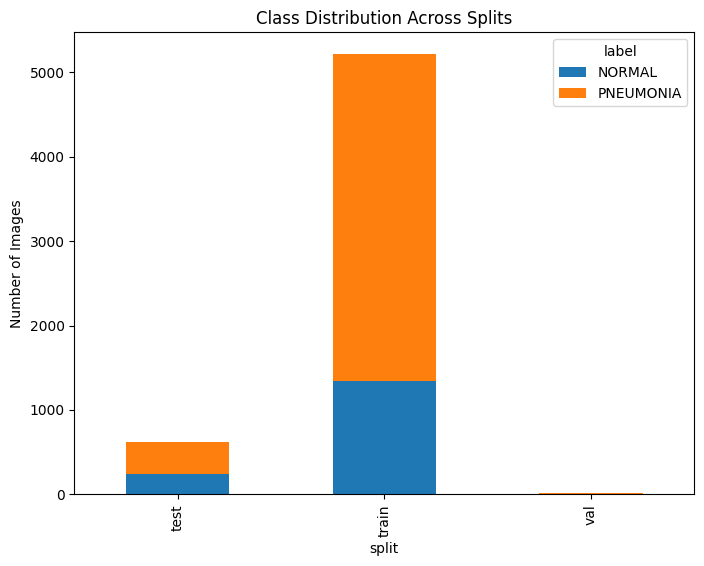

In [4]:
import matplotlib.pyplot as plt

# Count images in each split/category
counts = df.groupby(["split", "label"]).size().unstack()
print(counts)

# Visualization
counts.plot(kind="bar", stacked=True, figsize=(8,6))
plt.title("Class Distribution Across Splits")
plt.ylabel("Number of Images")
plt.show()

### Step 3: Remove Duplicates


Now, we'll ensure every entry in our dataframe points to a valid, unique image.
- **Corrupted Files**: We'll try to open each image. If it fails, we mark it for removal.
- **Duplicate Files**: We'll generate an **MD5 hash** (a unique signature) for each image file to find and remove exact duplicates.

In [5]:
def get_file_hash(filepath):
    """Calculates the MD5 hash of a file."""
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

valid_images = []
hashes = set()
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Verifying Images"):
    filepath = row['filepath']
    try:
        # 1. Check if it's a valid image file that can be opened
        img = Image.open(filepath)
        img.verify() # Verify that it is, in fact, an image

        # 2. Check for duplicates using hashing
        file_hash = get_file_hash(filepath)
        if file_hash in hashes:
            continue # Skip if it's a duplicate
        
        hashes.add(file_hash)
        valid_images.append(row)

    except Exception as e:
        print(f"Skipping corrupted file: {filepath} due to {e}")

# Create a new, clean DataFrame
clean_df = pd.DataFrame(valid_images)

print(f"\nOriginal image count: {len(df)}")
print(f"Clean image count: {len(clean_df)}")
print(f"Removed {len(df) - len(clean_df)} corrupted or duplicate images.")

Verifying Images: 100%|██████████| 5856/5856 [01:39<00:00, 58.58it/s] 



Original image count: 5856
Clean image count: 5824
Removed 32 corrupted or duplicate images.


### Step 4: Save Clean Metadata

This is the **final and most important step**. We save our clean DataFrame to a CSV file. This single file will be the input for our EDA and Model Building notebooks, ensuring a reliable and reproducible workflow.

In [6]:
# Save the clean metadata to a CSV file
output_path = "Data/clean_metadata.csv"
clean_df.to_csv(output_path, index=False)

print(f"✅ Clean metadata saved to {output_path}")
clean_df.head()

✅ Clean metadata saved to Data/clean_metadata.csv


,filepath,label,split
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,NORMAL,train
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,NORMAL,train
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,NORMAL,train
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,NORMAL,train
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,NORMAL,train
